In [2]:
#Run this if you want to force to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

c:\Users\fisica\Documents\Julian\mnist_fpga\mnist_fpga_hls4ml\mf_env\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(



=== Resumen ===
      model                                  path  exists  filesize_bytes  loaded  params_count  weights_total  weights_zeros  sparsity_fraction  eval_loss  eval_accuracy  inference_time_total_s  inference_time_per_sample_ms
    student    models/MLP/studentModelMnistMLP.h5    True          234392    True         52650          52650          26272           0.498993   0.396954         0.8848                0.297188                      0.029719
    teacher    models/MLP/teacherModelMnistMLP.h5    True         1305936    True        105990         105990              0           0.000000   0.165111         0.9675                0.148015                      0.014801
teacher_qat models/MLP/teacherModelQATMnistMLP.h5    True         1312488    True        105990         105990              0           0.000000   0.442293         0.8787                0.322259                      0.032226


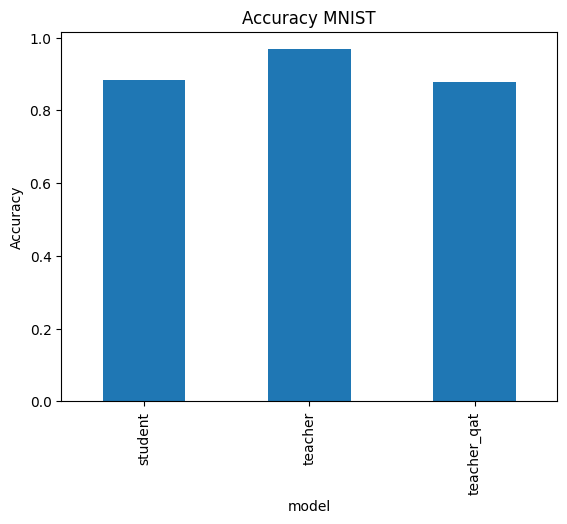

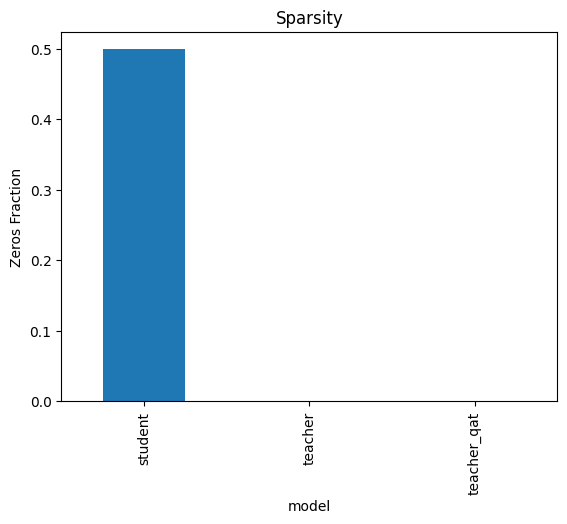


Resumen guardado en mnist_summaryMLP.csv


In [3]:
#!/usr/bin/env python3
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)


# === RUTA LOCAL (ajustada a tu PC) ===
MODEL_DIR = "models/MLP/"


model_files = {
    "student": os.path.join(MODEL_DIR, "studentModelMnistMLP.h5"),
    "teacher": os.path.join(MODEL_DIR, "teacherModelMnistMLP.h5"),
    "teacher_qat": os.path.join(MODEL_DIR, "teacherModelQATMnistMLP.h5")
}

# === Carga MNIST ===
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_test.astype("float32") / 255.0
x_test_flat = x_test.reshape((x_test.shape[0], -1))

results = []

def safe_load_model(path):
    try:
        model = load_model(path,custom_objects=co)
        return model, None
    except Exception as e:
        return None, str(e)

for name, path in model_files.items():
    info = {"model": name, "path": path, "exists": os.path.exists(path)}

    if not os.path.exists(path):
        info["error"] = "file not found"
        results.append(info)
        continue

    info["filesize_bytes"] = os.path.getsize(path)

    model, err = safe_load_model(path)
    if err:
        info["error"] = f"load_error: {err}"
        results.append(info)
        continue

    info["loaded"] = True

    # Parámetros
    info["params_count"] = model.count_params()

    # Sparsity
    weights = model.get_weights()
    total = sum(w.size for w in weights)
    zeros = sum(np.sum(w == 0.0) for w in weights)

    info["weights_total"] = total
    info["weights_zeros"] = zeros
    info["sparsity_fraction"] = zeros / total

    # Evaluación
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    loss, acc = model.evaluate(x_test_flat, y_test, verbose=0)
    info["eval_loss"] = loss
    info["eval_accuracy"] = acc

    # Latencia
    model.predict(x_test_flat[:128], batch_size=128, verbose=0)
    t0 = time.time()
    model.predict(x_test_flat, batch_size=256, verbose=0)
    t1 = time.time()
    info["inference_time_total_s"] = t1 - t0
    info["inference_time_per_sample_ms"] = (t1 - t0) / len(x_test_flat) * 1000

    results.append(info)

# === DataFrame ===
df = pd.DataFrame(results)
print("\n=== Resumen ===")
print(df.to_string(index=False))

# === Gráficas ===
if "eval_accuracy" in df:
    df.set_index("model")["eval_accuracy"].plot(kind="bar",
                                                title="Accuracy MNIST")
    plt.ylabel("Accuracy")
    plt.show()

if "sparsity_fraction" in df:
    df.set_index("model")["sparsity_fraction"].plot(kind="bar",
                                                    title="Sparsity")
    plt.ylabel("Zeros Fraction")
    plt.show()

# === CSV ===
df.to_csv("mnist_summaryMLP.csv", index=False)
print("\nResumen guardado en mnist_summaryMLP.csv")


c:\Users\fisica\Documents\Julian\mnist_fpga\mnist_fpga_hls4ml\mf_env\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(



=== Resumen ===
      model                                  path  exists  filesize_bytes  loaded  params_count  weights_total  weights_zeros  sparsity_fraction  eval_loss  eval_accuracy  inference_time_total_s  inference_time_per_sample_ms
    student    models/CNN/studentModelMnistCNN.h5    True          273720    True         58474          58474          29160           0.498683   0.362727         0.8927                1.841990                      0.184199
    teacher    models/CNN/teacherModelMnistCNN.h5    True         2764184    True        225990         225990              3           0.000013   0.070524         0.9893                0.782424                      0.078242
teacher_qat models/CNN/teacherModelQATMnistCNN.h5    True         1419120    True        112774         112774              0           0.000000   0.116586         0.9726                1.610774                      0.161077


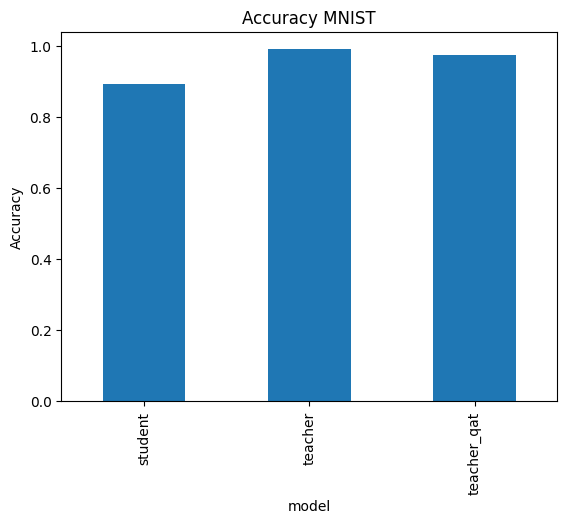

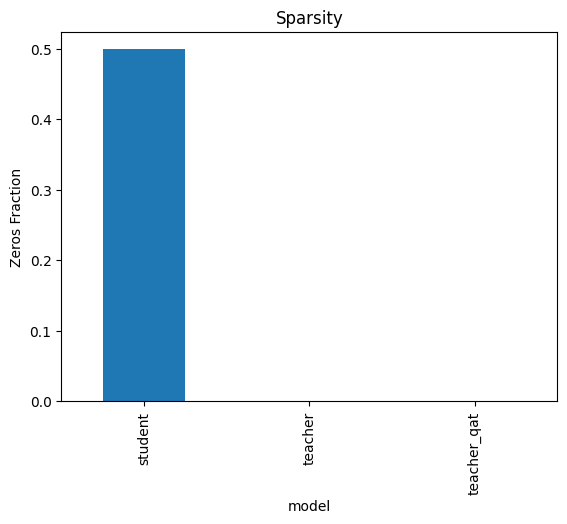


Resumen guardado en mnist_summaryCNN.csv


In [4]:
#!/usr/bin/env python3
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

# --- QKeras imports ---
from qkeras.utils import _add_supported_quantized_objects

# Registrar objetos cuantizados
co = {}
_add_supported_quantized_objects(co)


# === RUTA LOCAL (ajustada a tu PC) ===
MODEL_DIR = "models/CNN/"

model_files = {
    "student": os.path.join(MODEL_DIR, "studentModelMnistCNN.h5"),
    "teacher": os.path.join(MODEL_DIR, "teacherModelMnistCNN.h5"),
    "teacher_qat": os.path.join(MODEL_DIR, "teacherModelQATMnistCNN.h5")
}


# === Carga MNIST ===
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalización
x_test = x_test.astype("float32") / 255.0

# Añadir canal: (N, 28, 28, 1)
x_test = x_test[..., tf.newaxis]


# === Función de carga segura ===
def safe_load_model(path):
    try:
        model = load_model(path, custom_objects=co)
        return model, None
    except Exception as e:
        return None, str(e)


results = []

for name, path in model_files.items():

    info = {"model": name, "path": path, "exists": os.path.exists(path)}

    # Verificar archivo
    if not os.path.exists(path):
        info["error"] = "file not found"
        results.append(info)
        continue

    info["filesize_bytes"] = os.path.getsize(path)

    model, err = safe_load_model(path)
    if err:
        info["error"] = f"load_error: {err}"
        results.append(info)
        continue

    info["loaded"] = True

    # Parámetros
    info["params_count"] = model.count_params()

    # Sparsity
    weights = model.get_weights()
    total = sum(w.size for w in weights)
    zeros = sum(np.sum(w == 0.0) for w in weights)

    info["weights_total"] = total
    info["weights_zeros"] = zeros
    info["sparsity_fraction"] = zeros / total

    # Evaluación
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    info["eval_loss"] = loss
    info["eval_accuracy"] = acc

    # === Latencia ===
    # Calentamiento
    model.predict(x_test[:256], batch_size=256, verbose=0)

    t0 = time.time()
    model.predict(x_test, batch_size=256, verbose=0)
    t1 = time.time()

    info["inference_time_total_s"] = t1 - t0
    info["inference_time_per_sample_ms"] = (t1 - t0) / len(x_test) * 1000

    results.append(info)


# === DataFrame ===
df = pd.DataFrame(results)
print("\n=== Resumen ===")
print(df.to_string(index=False))


# === Gráficas ===
plt.figure()
df.set_index("model")["eval_accuracy"].plot(kind="bar", title="Accuracy MNIST")
plt.ylabel("Accuracy")
plt.show()

plt.figure()
df.set_index("model")["sparsity_fraction"].plot(kind="bar", title="Sparsity")
plt.ylabel("Zeros Fraction")
plt.show()


# === CSV ===
df.to_csv("mnist_summaryCNN.csv", index=False)
print("\nResumen guardado en mnist_summaryCNN.csv")
